In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.callbacks import Callback
from tensorflow.keras.optimizers import RMSprop


In [20]:
all_df = pd.read_csv('cleanAll7Year.csv', delimiter=',')
all_df=all_df.sort_values(['year', 'month','day','day_date','start_hour'], ascending=[True, True,True,True,True])
all_df.head(4)

,date,date_id,wind,desc,temp,baro,hum,year,month,day,day_date,start_hour,end_hour
3037,"Monday, January 5, 2015, 12:00 am — 6:00 am",1.420416e+12,1.864,Overcast.,39.2,30.47,94,2015,1,0,5,00:00,06:00
3038,"Monday, January 5, 2015, 6:00 am — 12:00 pm",1.420438e+12,3.728,Partly sunny.,48.2,30.40,93,2015,1,0,5,06:00,12:00
3039,"Monday, January 5, 2015, 12:00 pm — 6:00 pm",1.420459e+12,8.078,Partly sunny.,50.0,30.32,81,2015,1,0,5,12:00,18:00
3040,"Monday, January 5, 2015, 6:00 pm — 12:00 am",1.420481e+12,7.457,Overcast.,48.2,30.24,75,2015,1,0,5,18:00,00:00


# Split data: train:7000 records/ test:3222 records

In [21]:
Tp = 7000
train = np.array(all_df['temp'][:Tp])
test = np.array(all_df['temp'][Tp:])
print(all_df.shape)
print("Train data length:", train.shape)
print("Test data length:", test.shape)

(10222, 13)
Train data length: (7000,)
Test data length: (3222,)


#Train and Test shape :
 is a one-row array like this: array([39.2, ... ,55.4]) and I reshape(-1,1)to convert array to one column array.
# Plot : 
show split dataset to train and test :)

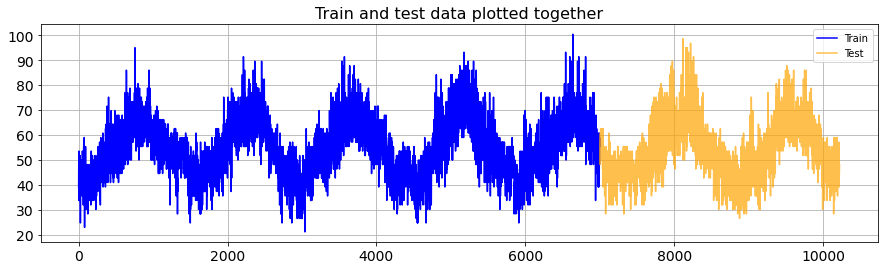

In [8]:
train=train.reshape(-1,1)
test=test.reshape(-1,1)
plt.figure(figsize=(15,4))
plt.title("Train and test data plotted together",fontsize=16)
plt.plot(np.arange(Tp),train,c='blue')
plt.plot(np.arange(Tp,10222),test,c='orange',alpha=0.7)
plt.legend(['Train','Test'])
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# Step:
shows step of prediction, I pass 4 spans to predict the 5th one. If your dataset splits into 10 spans, you can set step= 9 to predict the 10th span.
# Example: 
x = [1,2,3,4,5,6,7,8,9,10]
for step=1, x input  and its y prediction become:

x  y

1  2

2  3

3  4

4  5

..

9  10

for step=3, x and y contain:
x         y

1,2,3   4

2,3,4   5

3,4,5   6

4,5,6   7

...

7,8,9   10

As you have noticed the sizes of x input and y output become different. I'll fix it by adding step size into the training and test data.

In [9]:
step = 4
# add step elements into train and test
test = np.append(test,np.repeat(test[-1,],step))
train = np.append(train,np.repeat(train[-1,],step))
print("Train data length:", train.shape)
print("Test data length:", test.shape)

Train data length: (7004,)
Test data length: (3226,)


In [10]:
# convert dataset matrix
def convertToMatrix(data, step):
    X, Y =[], []
    for i in range(len(data)-step):
        d=i+step  
        X.append(data[i:d,])
        Y.append(data[d,])
    return np.array(X), np.array(Y)

# RNN model requires three-dimensional input data.
trainX,trainY =convertToMatrix(train,step)
testX,testY =convertToMatrix(test,step)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
print("Training data shape:", trainX.shape,', ',trainY.shape)
print("Test data shape:", testX.shape,', ',testY.shape)

Training data shape: (7000, 1, 4) ,  (7000,)
Test data shape: (3222, 1, 4) ,  (3222,)


In [11]:
# create model
def build_simple_rnn(num_units=32, embedding=4,num_dense=8,lr=0.001):
    model = Sequential()
    model.add(SimpleRNN(units=num_units, input_shape=(1,embedding), activation="relu"))
    model.add(Dense(num_dense, activation="relu"))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=RMSprop(lr=lr),metrics=['mse'])
    
    return model

In [12]:
model_temp = build_simple_rnn(num_units=32,num_dense=8,embedding=4,lr=0.0005)
model_temp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1184      
                                                                 
 dense (Dense)               (None, 8)                 264       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,457
Trainable params: 1,457
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [13]:
class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch+1) % 5 == 0 and epoch>0:
            print("Epoch number {} done".format(epoch+1))

In [27]:
# fit model and define number of epochs and batch size
batch_size=2
num_epochs = 10
model_temp.fit(trainX,trainY, 
          epochs=num_epochs, 
          batch_size=batch_size, 
          callbacks=[MyCallback()],verbose=0)

Epoch number 5 done
Epoch number 10 done


In [23]:
# predict
trainPredict = model_temp.predict(trainX)
testPredict= model_temp.predict(testX)
predicted=np.concatenate((trainPredict,testPredict),axis=0)

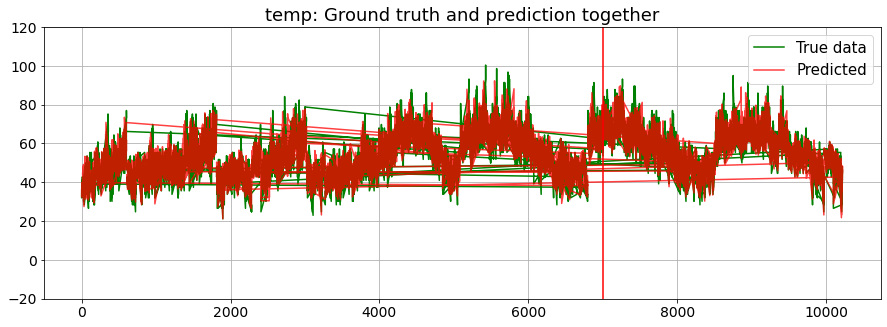

In [26]:
# compare ground truth and predcition of model results
index = all_df.index.values

plt.figure(figsize=(15,5))
plt.title("temp: Ground truth and prediction together",fontsize=18)
plt.plot(index,all_df['temp'],c='green')
plt.plot(index,predicted,c='red',alpha=0.75)
plt.legend(['True data','Predicted'],fontsize=15)
plt.axvline(x=Tp, c="r")
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(-20,120)
plt.show()